In [19]:
import pandas as pd
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
#load and preprocess the data
df = pd.read_csv("insurance.csv")
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


/var/folders/tg/g161x0m50lxgx68hfwk_3qk80000gn/T/ipykernel_28989/614486355.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby('region')['charges'].agg(['mean', 'count', 'std'])


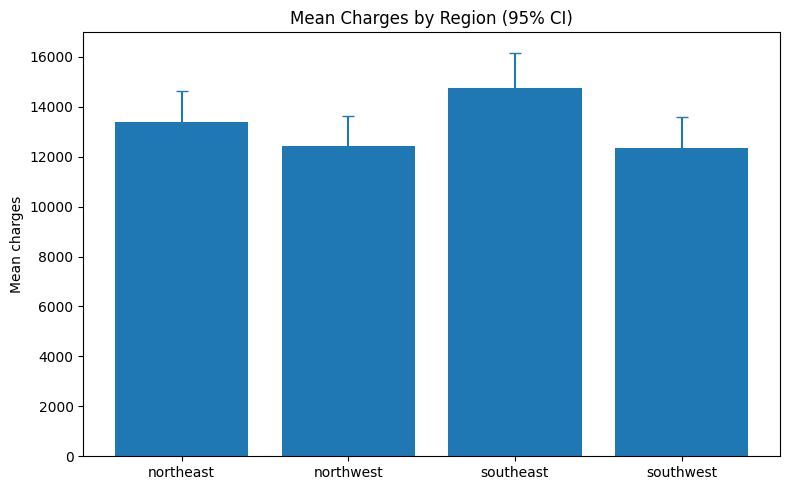

In [7]:
df['region'] = df['region'].astype('category')
df['log_charges'] = np.log1p(df['charges'])

agg = df.groupby('region')['charges'].agg(['mean', 'count', 'std'])
agg['sem'] = agg['std'] / np.sqrt(agg['count'])
agg['ci95'] = 1.96 * agg['sem']        # ~95% CI

regions = agg.index.astype(str).tolist()
y = agg['mean'].to_numpy()
yerr = agg['ci95'].to_numpy()

x = np.arange(len(regions))

plt.figure(figsize=(8,5))
plt.bar(x, y)
plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=4)
plt.xticks(x, regions)
plt.ylabel("Mean charges")
plt.title("Mean Charges by Region (95% CI)")
plt.tight_layout()
plt.show()


/var/folders/tg/g161x0m50lxgx68hfwk_3qk80000gn/T/ipykernel_28989/3666973773.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_log = df.groupby('region')['log_charges'].agg(['mean', 'count', 'std'])


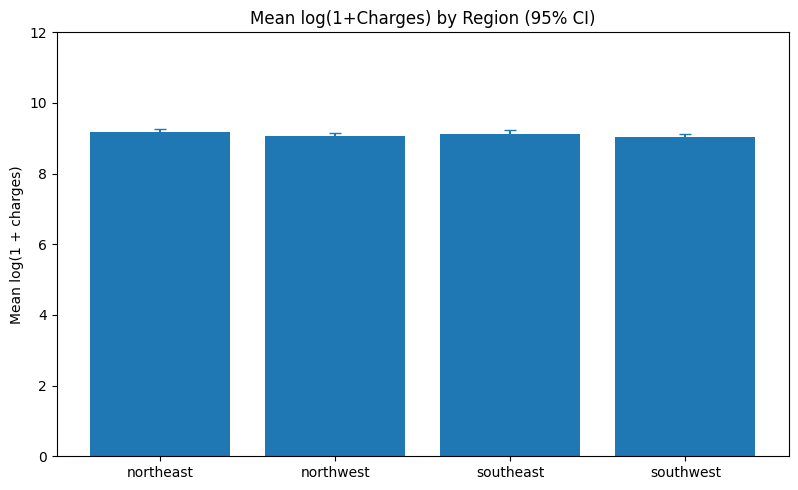

In [8]:
agg_log = df.groupby('region')['log_charges'].agg(['mean', 'count', 'std'])
agg_log['sem']  = agg_log['std'] / np.sqrt(agg_log['count'])
agg_log['ci95'] = 1.96 * agg_log['sem']

regions = agg_log.index.astype(str).tolist()
y = agg_log['mean'].to_numpy()
yerr = agg_log['ci95'].to_numpy()

x = np.arange(len(regions))

plt.figure(figsize=(8,5))
plt.bar(x, y)
plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=4)
plt.xticks(x, regions)
plt.ylabel("Mean log(1 + charges)")
plt.title("Mean log(1+Charges) by Region (95% CI)")
plt.tight_layout()
plt.ylim(0, 12)     # charges in dollars
plt.show()

/var/folders/tg/g161x0m50lxgx68hfwk_3qk80000gn/T/ipykernel_28989/2302219080.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([female, male], labels=['Female', 'Male'], showfliers=True)  # set showfliers=False to hide outliers


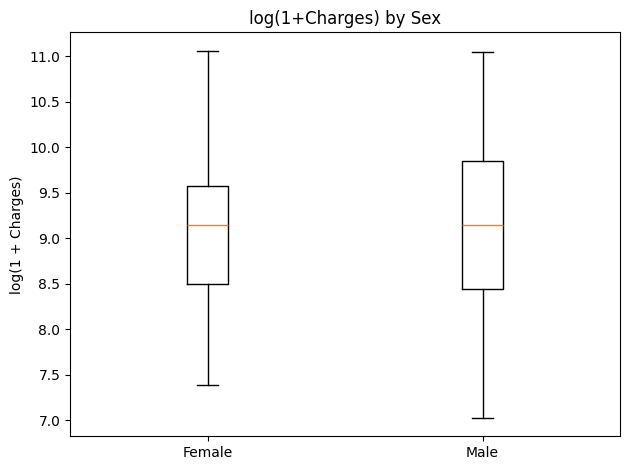

In [9]:
# 1) Create a log-transformed column (handles zero safely)
#    log(1 + x) so there’s no issue if any charge == 0

# (Optional) sanity check for negatives
assert (df['charges'] >= 0).all(), "Found negative charges; log1p is undefined there."

# 2) Ensure categorical for clean grouping
df['sex'] = df['sex'].astype('category')

# 3) Side-by-side boxplot of log-transformed charges by sex
female = df.loc[df['sex'].str.lower() == 'female', 'log_charges'].values
male   = df.loc[df['sex'].str.lower() == 'male',   'log_charges'].values

plt.figure()
plt.boxplot([female, male], labels=['Female', 'Male'], showfliers=True)  # set showfliers=False to hide outliers
plt.ylabel('log(1 + Charges)')
plt.title('log(1+Charges) by Sex')
plt.tight_layout()
plt.show()

In [10]:
df.dtypes

age               int64
sex            category
bmi             float64
children          int64
smoker           object
region         category
charges         float64
log_charges     float64
dtype: object

          count          mean           std        min          25%  \
children                                                              
0         574.0  12365.975602  12023.293942  1121.8739  2734.421150   
1         324.0  12731.171832  11823.631451  1711.0268  4791.643175   
2         240.0  15073.563734  12891.368347  2304.0022  6284.939438   
3         157.0  15355.318367  12330.869484  3443.0640  6652.528800   
4          25.0  13850.656311   9139.223321  4504.6624  7512.267000   
5          18.0   8786.035247   3808.435525  4687.7970  5874.973900   

                  50%           75%          max  
children                                          
0          9856.95190  14440.123825  63770.42801  
1          8483.87015  15632.052050  58571.07448  
2          9264.97915  20379.276748  49577.66240  
3         10600.54830  19199.944000  60021.39897  
4         11033.66170  17128.426080  40182.24600  
5          8589.56505  10019.943975  19023.26000  


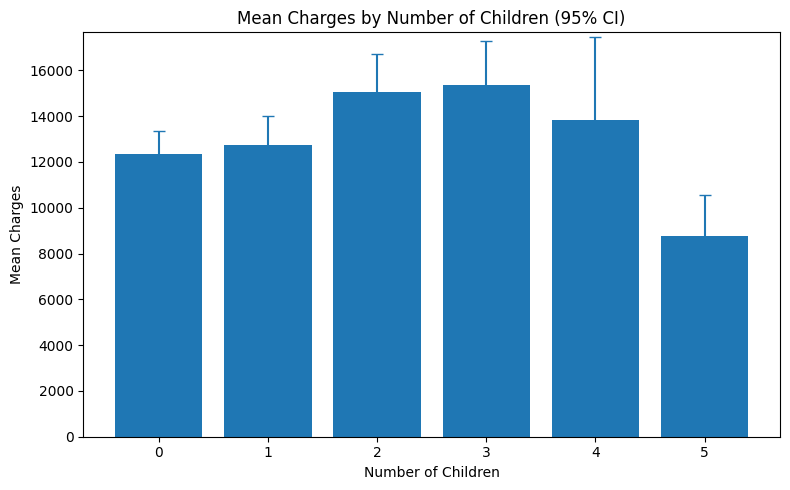

In [11]:
by_kids = df.groupby('children')['charges'].describe()
print(by_kids)

# -------- 2) Mean charges bar chart (+ 95% CI) --------
agg = df.groupby('children')['charges'].agg(['mean', 'count', 'std'])
agg['sem']  = agg['std'] / np.sqrt(agg['count'])
agg['ci95'] = 1.96 * agg['sem']  # ~95% CI

kids = agg.index.to_numpy()
y    = agg['mean'].to_numpy()
yerr = agg['ci95'].to_numpy()

plt.figure(figsize=(8,5))
plt.bar(kids, y)
plt.errorbar(kids, y, yerr=yerr, fmt='none', capsize=4)
plt.xlabel("Number of Children")
plt.ylabel("Mean Charges")
plt.title("Mean Charges by Number of Children (95% CI)")
plt.xticks(kids)
plt.ylim(0, y.max()*1.15)
plt.tight_layout()
plt.show()


# Feature Engineering

In [24]:
# Ensure smoker is binary (1=yes, 0=no)
df["smoker_bin"] = df["smoker"].map({"yes": 1, "no": 0}).astype(int)

# --- Interaction features ---
df["bmi_x_smoker"] = df["bmi"] * df["smoker_bin"]
df["age_x_smoker"] = df["age"] * df["smoker_bin"]

# (optional) keep everything tidy
feature_cols = ["age","bmi","children","smoker_bin","bmi_x_smoker","age_x_smoker","charges"]
df[feature_cols].head()

X = df[["age","bmi","children","smoker_bin","bmi_x_smoker","age_x_smoker"]]
y = df["charges"]

# Linear Regression Models

[OLS] RMSE: 5,378.30 | R²: 0.8137


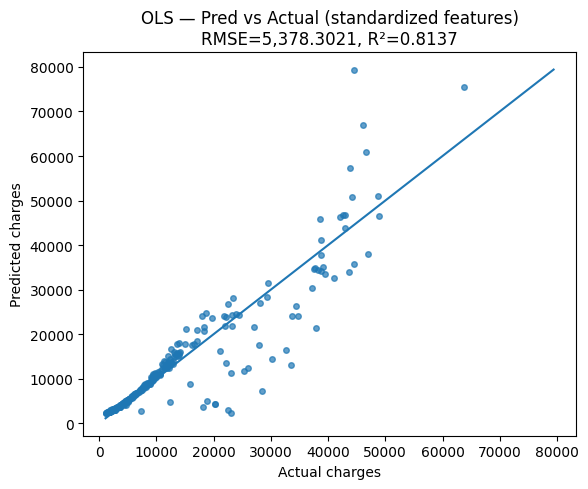

[Ridge] RMSE: 5,358.92 | R²: 0.8150
  alpha_ = 0.3162


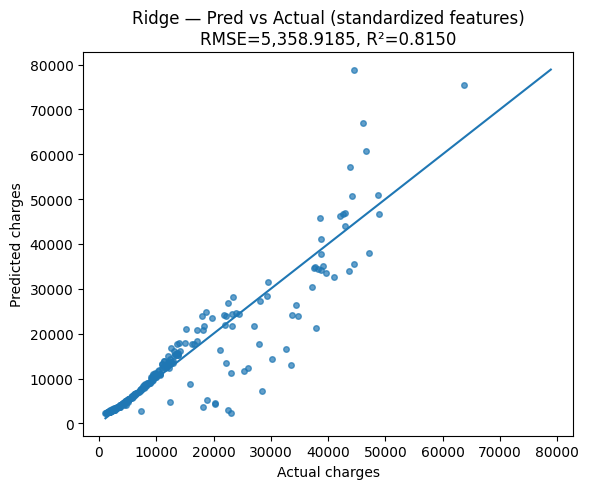

[Lasso] RMSE: 5,349.60 | R²: 0.8157
  alpha_ = 0.0007


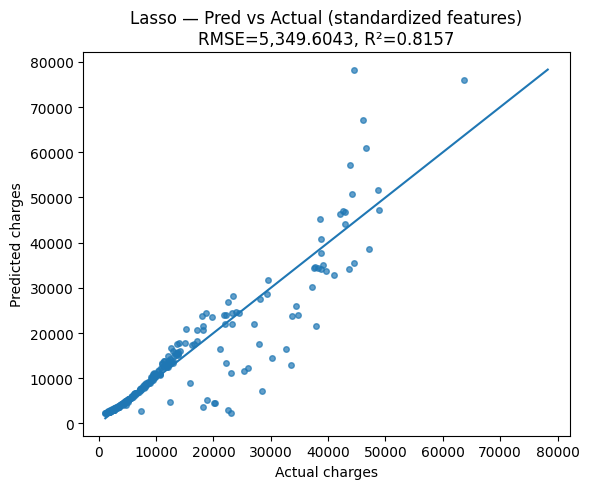

[ElasticNet] RMSE: 5,349.60 | R²: 0.8157
  alpha_ = 0.0007
  l1_ratio_ = 1.0000


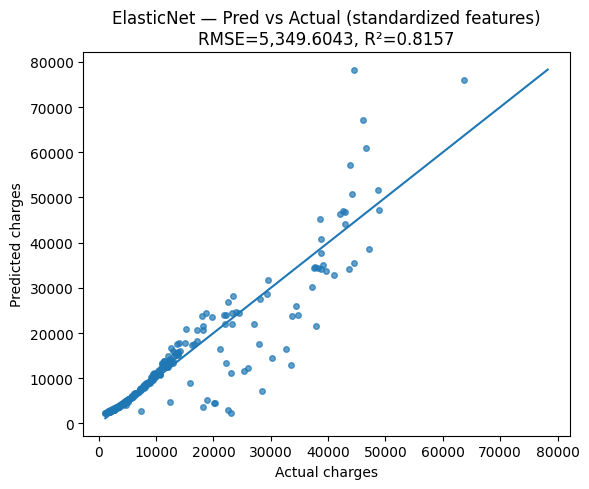

In [31]:
# --- CONFIG ---
USE_LOG_TARGET = True
features = ['age', 'bmi', 'sex', 'smoker', 'region', 'children', 'bmi_x_smoker', 'age_x_smoker']
target   = 'charges'

X = df[features].copy()
y = np.log1p(df[target]) if USE_LOG_TARGET else df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_cols = ['age', 'bmi', 'children', 'bmi_x_smoker', 'age_x_smoker']
cat_cols = ['sex', 'smoker', 'region']

# ✅ Preprocess: scale numeric + one-hot categorical
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", Pipeline([
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
            ("scale", StandardScaler(with_mean=False))  # scale one-hot columns too
        ]), cat_cols)
    ]
)

# --- Models ---
ols = LinearRegression()
ridge = RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5)
lasso = LassoCV(alphas=np.logspace(-4, 1, 30), cv=5, max_iter=10000, n_jobs=-1, random_state=42)
enet  = ElasticNetCV(l1_ratio=[0.15, 0.3, 0.5, 0.7, 0.85, 1.0],
                     alphas=np.logspace(-4, 1, 30), cv=5, max_iter=20000, n_jobs=-1, random_state=42)

models = {"OLS": ols, "Ridge": ridge, "Lasso": lasso, "ElasticNet": enet}

def eval_and_plot(name, model):
    pipe = Pipeline([
        ("prep", pre),
        ("model", model),
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    if USE_LOG_TARGET:
        y_true_plot = np.expm1(y_test)
        y_pred_plot = np.expm1(y_pred)
    else:
        y_true_plot = y_test
        y_pred_plot = y_pred

    mse = mean_squared_error(y_true_plot, y_pred_plot)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true_plot, y_pred_plot)

    print(f"[{name}] RMSE: {rmse:,.2f} | R²: {r2:.4f}")
    if hasattr(model, "alpha_"):
        print(f"  alpha_ = {model.alpha_:.4f}")
    if hasattr(model, "l1_ratio_"):
        print(f"  l1_ratio_ = {model.l1_ratio_:.4f}")

    plt.figure(figsize=(6,5))
    plt.scatter(y_true_plot, y_pred_plot, s=16, alpha=0.7)
    lo, hi = float(min(y_true_plot.min(), y_pred_plot.min())), float(max(y_true_plot.max(), y_pred_plot.max()))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("Actual charges")
    plt.ylabel("Predicted charges")
    plt.title(f"{name} — Pred vs Actual (standardized features)\nRMSE={rmse:,.4f}, R²={r2:.4f}")
    plt.tight_layout()
    plt.show()

for name, mdl in models.items():
    eval_and_plot(name, mdl)

## With Hyperparameter Tuning



[OLS] RMSE: 5,378.30 | R²: 0.8137


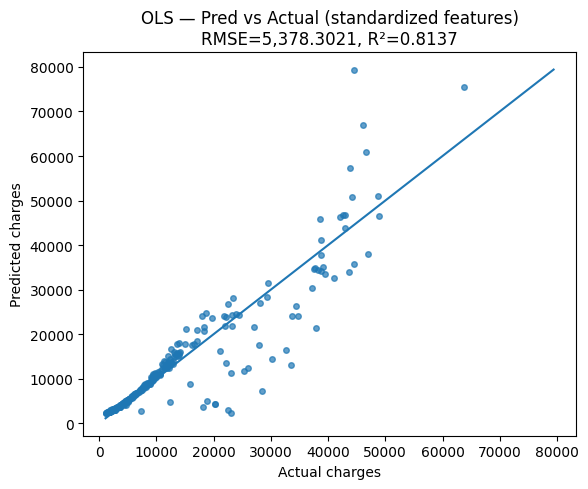

[Ridge] RMSE: 5,366.19 | R²: 0.8145
  alpha_ = 0.1963


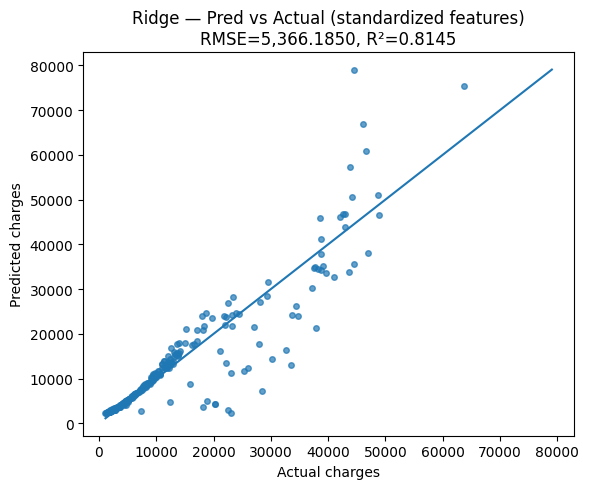

[Lasso] RMSE: 5,726.55 | R²: 0.7888
  alpha_ = 0.0173


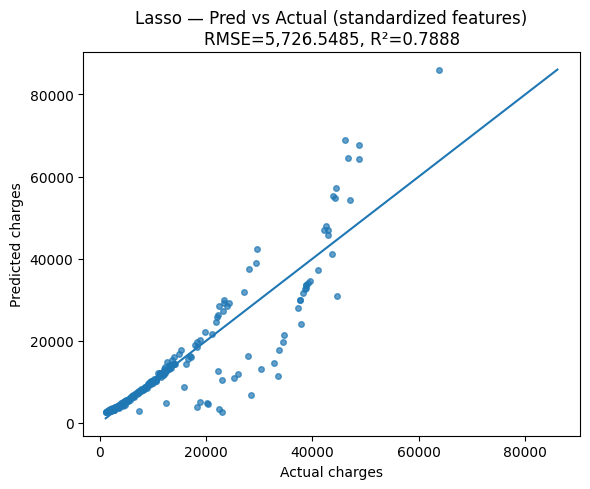

[ElasticNet] RMSE: 4,936.53 | R²: 0.8430
  alpha_ = 0.0173
  l1_ratio_ = 0.1500


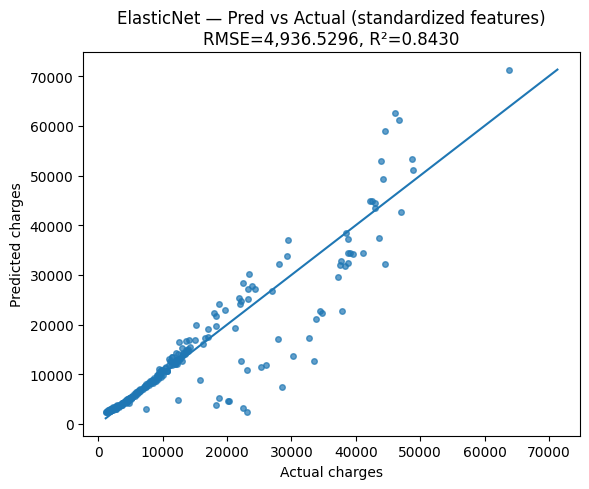

In [ ]:
# --- your existing split/preprocessor ---
X = df[features].copy()
y = np.log1p(df[target]) if USE_LOG_TARGET else df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ['age','bmi','children','bmi_x_smoker','age_x_smoker']),
        ("cat", Pipeline([
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
            ("scale", StandardScaler(with_mean=False))
        ]), ['sex','smoker','region'])
    ]
)

# --- fit preprocessor, get design matrix for theory-based tuning ---
Xtr = pre.fit_transform(X_train)
ytr = y_train.values if hasattr(y_train, "values") else y_train

n = Xtr.shape[0]
# alpha_max for Lasso/EN (sklearn’s formulation): (1/n) * ||X^T y||_inf
alpha_max = (np.abs(Xtr.T @ ytr).max()) / n

# Build data-driven alpha grids
def make_alpha_grid(alpha_max, n_alphas=30, eps=1e-3):
    alpha_min = alpha_max * eps
    return np.logspace(np.log10(alpha_min), np.log10(alpha_max), n_alphas)

lasso_alphas = make_alpha_grid(alpha_max, n_alphas=30, eps=1e-3)

# For ElasticNet, alpha_max depends on l1_ratio; generate per l1
l1_grid = [0.15, 0.3, 0.5, 0.7, 0.85, 1.0]
enet_alphas_by_l1 = {
    l1: make_alpha_grid(alpha_max / max(l1, 1e-6), n_alphas=30, eps=1e-3)
    for l1 in l1_grid
}
# Sklearn’s ElasticNetCV accepts one alpha grid for all l1_ratio values.
# A practical trick: take the union and sort unique.
enet_alphas = np.unique(np.concatenate([v for v in enet_alphas_by_l1.values()]))

ols   = LinearRegression()
ridge = RidgeCV(alphas=None)  # we’ll set a data-driven grid below
lasso = LassoCV(alphas=lasso_alphas, cv=5, max_iter=20000, n_jobs=-1, random_state=42)
enet  = ElasticNetCV(l1_ratio=l1_grid, alphas=enet_alphas, cv=5, max_iter=30000, n_jobs=-1, random_state=42)

# SVD on training design (no need for full SVD)
# Use randomized SVD if very wide/tall; here plain SVD is fine for moderate size
u, s, vt = np.linalg.svd(Xtr, full_matrices=False)
s2 = s**2
s2_min, s2_max = s2.min(), s2.max()

ridge_alphas = np.logspace(np.log10(max(s2_min, 1e-8)/100),
                           np.log10(s2_max*100),
                           25)

ridge = RidgeCV(alphas=ridge_alphas, cv=None, store_cv_results=False)

def make_alpha_grids(preprocessor, X_train, y_train, l1_grid=(0.15,0.3,0.5,0.7,0.85,1.0),
                     n_alphas=30, eps=1e-3):
    Xtr = preprocessor.fit_transform(X_train)
    ytr = y_train.values if hasattr(y_train, "values") else y_train
    n = Xtr.shape[0]

    # Lasso/EN alpha_max
    alpha_max = (np.abs(Xtr.T @ ytr).max()) / n
    lasso_alphas = np.logspace(np.log10(alpha_max*eps), np.log10(alpha_max), n_alphas)

    # EN grid (union across l1_ratio)
    enet_alphas = np.unique(np.concatenate([
        np.logspace(np.log10((alpha_max/max(l1,1e-6))*eps),
                    np.log10(alpha_max/max(l1,1e-6)),
                    n_alphas)
        for l1 in l1_grid
    ]))

    # Ridge grid via spectrum of X
    u, s, vt = np.linalg.svd(Xtr, full_matrices=False)
    s2 = s**2
    ridge_alphas = np.logspace(np.log10(max(s2.min(), 1e-8)/100),
                               np.log10(s2.max()*100),
                               25)

    return lasso_alphas, enet_alphas, list(l1_grid), ridge_alphas

lasso_alphas, enet_alphas, l1_grid, ridge_alphas = make_alpha_grids(pre, X_train, y_train)

ols   = LinearRegression()
ridge = RidgeCV(alphas=ridge_alphas)
lasso = LassoCV(alphas=lasso_alphas, cv=5, max_iter=20000, n_jobs=-1, random_state=42)
enet  = ElasticNetCV(l1_ratio=l1_grid, alphas=enet_alphas, cv=5, max_iter=30000, n_jobs=-1, random_state=42)

models = {"OLS": ols, "Ridge": ridge, "Lasso": lasso, "ElasticNet": enet}

def eval_and_plot(name, model):
    pipe = Pipeline([
        ("prep", pre),
        ("model", model),
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    if USE_LOG_TARGET:
        y_true_plot = np.expm1(y_test)
        y_pred_plot = np.expm1(y_pred)
    else:
        y_true_plot = y_test
        y_pred_plot = y_pred

    mse = mean_squared_error(y_true_plot, y_pred_plot)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true_plot, y_pred_plot)

    print(f"[{name}] RMSE: {rmse:,.2f} | R²: {r2:.4f}")
    if hasattr(model, "alpha_"):
        print(f"  alpha_ = {model.alpha_:.4f}")
    if hasattr(model, "l1_ratio_"):
        print(f"  l1_ratio_ = {model.l1_ratio_:.4f}")

    plt.figure(figsize=(6,5))
    plt.scatter(y_true_plot, y_pred_plot, s=16, alpha=0.7)
    lo, hi = float(min(y_true_plot.min(), y_pred_plot.min())), float(max(y_true_plot.max(), y_pred_plot.max()))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("Actual charges")
    plt.ylabel("Predicted charges")
    plt.title(f"{name} — Pred vs Actual (standardized features)\nRMSE={rmse:,.4f}, R²={r2:.4f}")
    plt.tight_layout()
    plt.show()

for name, mdl in models.items():
    eval_and_plot(name, mdl)

# Tree Based Models

[XGB] RMSE: 4,496.80 | R²: 0.870


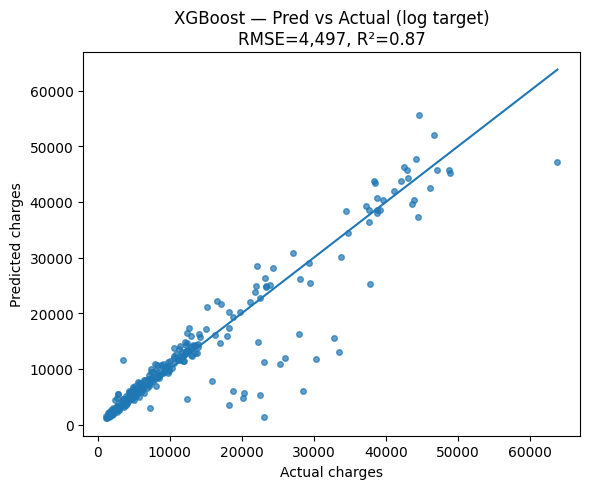

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

USE_LOG_TARGET = True  # set True to model log(1+charges)

features = ['age', 'sex', 'bmi', 'smoker', 'region', 'children']
target   = 'charges'

X = df[features].copy()
y = np.log1p(df[target]) if USE_LOG_TARGET else df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_cols = ['age', 'bmi', 'children']
cat_cols = ['sex', 'smoker', 'region']

pre = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
])

model = XGBRegressor(
    n_estimators=900, learning_rate=0.04, max_depth=4,
    subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1, tree_method="hist",
    reg_lambda=10.0  
)

pipe = Pipeline([("prep", pre), ("model", model)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
if USE_LOG_TARGET:  # invert for metrics in dollars
    y_true_plot = np.expm1(y_test)
    y_pred_plot = np.expm1(y_pred)
else:
    y_true_plot = y_test
    y_pred_plot = y_pred

rmse = mean_squared_error(y_true_plot, y_pred_plot) ** 0.5
r2   = r2_score(y_true_plot, y_pred_plot)
print(f"[XGB] RMSE: {rmse:,.2f} | R²: {r2:.3f}")

# Matplotlib: Predicted vs Actual
plt.figure(figsize=(6,5))
plt.scatter(y_true_plot, y_pred_plot, s=16, alpha=0.7)
lo, hi = float(min(y_true_plot.min(), y_pred_plot.min())), float(max(y_true_plot.max(), y_pred_plot.max()))
plt.plot([lo, hi], [lo, hi])
plt.xlabel("Actual charges")
plt.ylabel("Predicted charges")
ttl = "XGBoost — Pred vs Actual" + (" (log target)" if USE_LOG_TARGET else "")
plt.title(f"{ttl}\nRMSE={rmse:,.0f}, R²={r2:.2f}")
plt.tight_layout()
plt.show()

# Tree Based Models

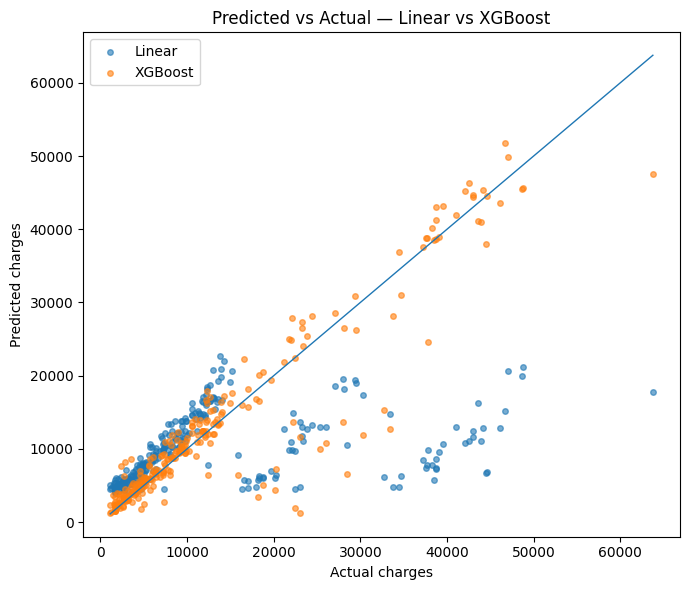

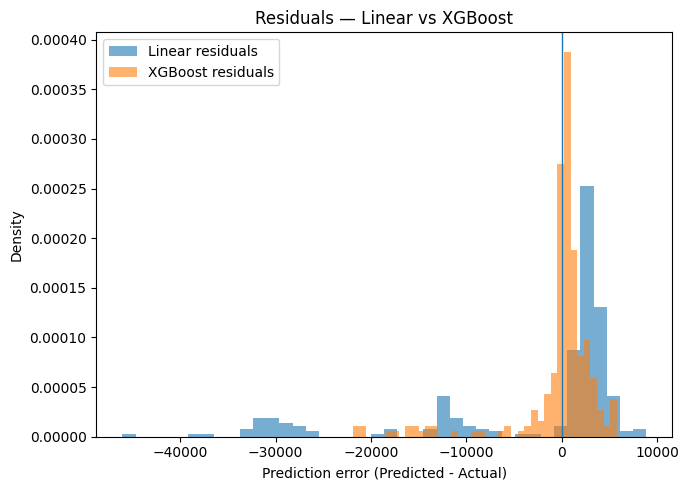

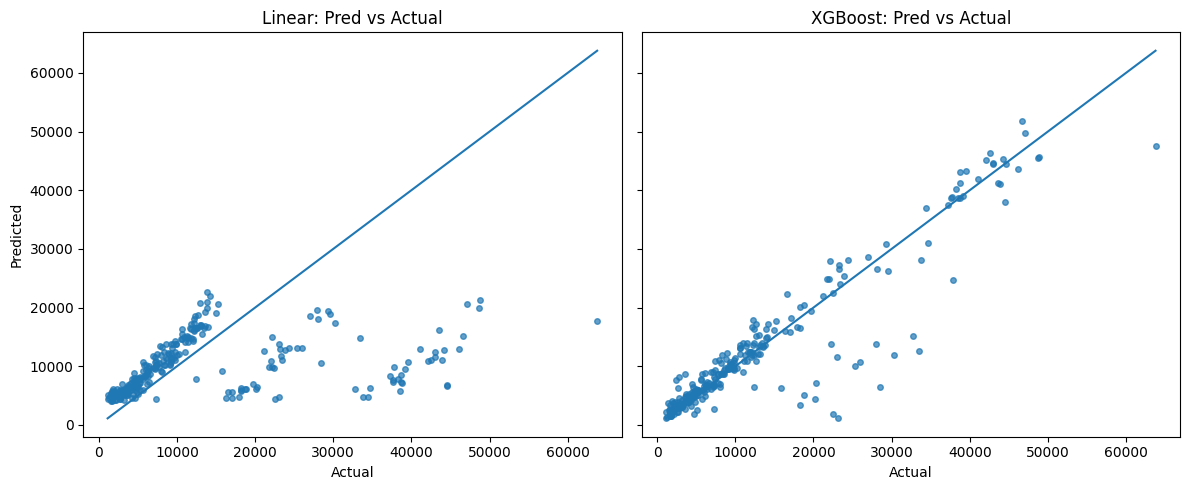

In [ ]:
# -------- 1) Predicted vs Actual (overlay) --------
plt.figure(figsize=(7,6))
plt.scatter(y_true_plot, y_pred_eval, s=16, alpha=0.6, label="Linear")
plt.scatter(y_true_plot, y_pred_plot,    s=16, alpha=0.6, label="XGBoost")

lo = float(min(y_true_plot.min(), y_pred_eval.min(), y_pred_plot.min()))
hi = float(max(y_true_plot.max(), y_pred_eval.max(), y_pred_plot.max()))
plt.plot([lo, hi], [lo, hi], linewidth=1)  # y = x reference

plt.xlabel("Actual charges")
plt.ylabel("Predicted charges")
plt.title("Predicted vs Actual — Linear vs XGBoost")
plt.legend()
plt.tight_layout()
plt.show()

# -------- 2) Residuals comparison (histograms) --------
res_lin = y_pred_eval - y_true_plot
res_xgb = y_pred_plot - y_true_plot

plt.figure(figsize=(7,5))
bins = 40
plt.hist(res_lin, bins=bins, alpha=0.6, density=True, label="Linear residuals")
plt.hist(res_xgb, bins=bins, alpha=0.6, density=True, label="XGBoost residuals")
plt.axvline(0, linewidth=1)  # zero-error line
plt.xlabel("Prediction error (Predicted - Actual)")
plt.ylabel("Density")
plt.title("Residuals — Linear vs XGBoost")
plt.legend()
plt.tight_layout()
plt.show()

# (Optional) If you want a side-by-side panel instead of overlay for Fig 1:
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
axes[0].scatter(y_true_plot, y_pred_eval, s=16, alpha=0.7)
lo1 = float(min(y_true_plot.min(), y_pred_eval.min()))
hi1 = float(max(y_true_plot.max(), y_pred_eval.max()))
axes[0].plot([lo1, hi1], [lo1, hi1])
axes[0].set_title("Linear: Pred vs Actual")
axes[0].set_xlabel("Actual"); axes[0].set_ylabel("Predicted")

axes[1].scatter(y_true_plot, y_pred_plot, s=16, alpha=0.7)
lo2 = float(min(y_true_plot.min(), y_pred_plot.min()))
hi2 = float(max(y_true_plot.max(), y_pred_plot.max()))
axes[1].plot([lo2, hi2], [lo2, hi2])
axes[1].set_title("XGBoost: Pred vs Actual")
axes[1].set_xlabel("Actual")

plt.tight_layout(); plt.show()